In [1]:
import pandas as pd
import numpy as np
import os
import pickle

In [2]:
results_dir = 'logs/AdaCGP/cgp_simulated/2024-09-15/22-12-34'

def read_sweep_eval_results(results_dir):
    # walk the results dir
    cols = ['graph_type', 'N', 'use_path_1', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed']
    numeric_cols = ['N', 'gamma', 'lambda', 'nu', 'mus.0', 'mus.1', 'mus.2', 'seed']
    results_cols = ['nmse_pred_alg1', 'nmse_pred_from_h_alg1', 'nmse_w_alg1', 'pce_alg1', 'p_miss_alg1', 'p_false_alarm_alg1', \
            'nmse_pred_alg2', 'nmse_pred_from_h_alg2', 'nmse_w_alg2', 'pce_alg2', 'p_miss_alg2', 'p_false_alarm_alg2']
    all_cols = cols + results_cols
    data = {col: [] for col in all_cols}
    data['cfg_path'] = []

    # walk the results dir
    # with folders structured as in cols
    for root, dirs, files in os.walk(results_dir):
        for file in files:
            if file == 'eval_results.txt':
                # extract the parameters
                parts = root.split('/')
                cfg_path = os.path.join(root, '.hydra', 'config.yaml')
                data['cfg_path'].append(cfg_path)
                data['seed'].append(parts[-1].split('_')[-1])
                mus_0, mus_1, mus_2 = parts[-2].split('_')[1:]
                data['mus.0'].append(mus_0)
                data['mus.1'].append(mus_1)
                data['mus.2'].append(mus_2)
                data['nu'].append(parts[-3].split('_')[-1])
                data['lambda'].append(parts[-4].split('_')[-1])
                data['gamma'].append(parts[-5].split('_')[-1])
                data['use_path_1'].append(parts[-6].split('_')[-1])
                data['N'].append(parts[-7].split('_')[-1])
                data['graph_type'].append(parts[-8].split('_')[-1])

                with open(os.path.join(root, file), 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        col, result = line.split(':')
                        col = col.strip()
                        result = result.strip()
                        data[col].append(result)
    return data, (cols, numeric_cols, results_cols, all_cols)

def get_best_as_pandas(data, metric, direction, numeric_cols, results_cols):
    df = pd.DataFrame(data)
    df[results_cols] = df[results_cols].astype(float).fillna(1e10)
    df[numeric_cols] = df[numeric_cols].astype(float)
    df = df[df['N'] <= 500]
    df_best = df.groupby(by=['graph_type', 'N', 'use_path_1']).apply(lambda x: x.sort_values(by=metric, ascending=True if direction == 'min' else False).head(1))
    return df_best

data, (cols, numeric_cols, results_cols, all_cols) = read_sweep_eval_results(results_dir)
df_best = get_best_as_pandas(data, 'nmse_pred_from_h_alg2', 'min', numeric_cols, results_cols)

In [3]:
alg1_cols = cols + ['nmse_pred_alg1', 'nmse_pred_from_h_alg1', 'nmse_w_alg1', 'pce_alg1', 'p_miss_alg1', 'p_false_alarm_alg1']
alg2_cols = cols + ['nmse_pred_alg2', 'nmse_pred_from_h_alg2', 'nmse_w_alg2', 'pce_alg2', 'p_miss_alg2', 'p_false_alarm_alg2']
results_cols = cols + ['nmse_pred', 'nmse_pred_from_h', 'nmse_w', 'pce', 'p_miss', 'p_false_alarm']

df_alg1 = df_best[alg1_cols]
df_alg1.columns = results_cols
df_alg1['algorithm'] = 'alg1'

df_alg2 = df_best[alg2_cols]
df_alg2.columns = results_cols
df_alg2['algorithm'] = 'alg2'

df_long = pd.concat([df_alg1, df_alg2], ignore_index=True)

df_long

/tmp/ipykernel_2931862/3200020220.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alg1['algorithm'] = 'alg1'
/tmp/ipykernel_2931862/3200020220.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alg2['algorithm'] = 'alg2'


,graph_type,N,use_path_1,gamma,lambda,nu,mus.0,mus.1,mus.2,seed,nmse_pred,nmse_pred_from_h,nmse_w,pce,p_miss,p_false_alarm,algorithm
0,ER,50.0,False,1.00,0.81,0.010,0.025,0.225,0.575,42.0,0.570559,0.631373,0.177114,1.000000,0.000000,0.996337,alg1
1,ER,50.0,True,1.80,0.83,0.005,0.075,0.250,1.000,42.0,0.642840,0.990002,1.000000,0.000000,1.000000,0.000000,alg1
2,ER,100.0,False,1.95,0.94,0.010,0.100,0.800,0.950,42.0,0.683495,0.643042,0.437777,0.988405,0.011595,0.501305,alg1
3,ER,100.0,True,1.70,0.92,0.005,0.100,0.975,0.775,42.0,0.718323,1.010462,1.000000,0.000000,1.000000,0.000000,alg1
4,ER,250.0,False,0.50,0.92,0.005,0.025,0.250,0.950,42.0,0.989698,0.990199,0.990385,0.992984,0.007016,0.992434,alg1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,SBM,100.0,True,1.50,0.93,0.010,0.150,0.775,0.775,42.0,0.630355,0.671469,0.533091,0.375000,0.625000,0.022949,alg2
60,SBM,250.0,False,0.90,0.91,0.005,0.350,0.600,0.425,42.0,0.955106,0.949102,0.945299,0.033991,0.966009,0.001380,alg2
61,SBM,250.0,True,0.90,0.95,0.015,0.025,0.350,0.025,42.0,0.779952,0.826859,0.734184,0.898126,0.101874,0.574376,alg2
62,SBM,500.0,False,1.90,0.89,0.010,0.450,0.875,0.725,42.0,0.995722,1.010118,0.998821,0.003609,0.996391,0.000065,alg2


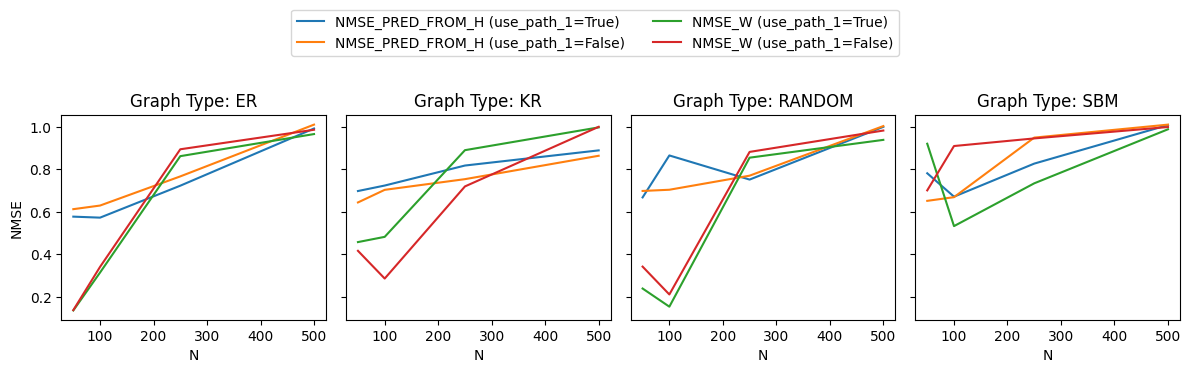

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# hue graph_type, x = N, y = nmse_pred_from_h
# data = df_long[df_long['algorithm'] == 'alg2']
# g = sns.FacetGrid(data, col="graph_type", hue="use_path_1", sharey=True)
# g.map(sns.lineplot, "N", "nmse_pred_from_h")
# g.add_legend()
# # change y axis title to $NMSE_{pred}$
# g.set(ylabel='$NMSE_{pred}$')
# plt.show()

# g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col="graph_type", hue="use_path_1", sharey=True)
# g.map(sns.lineplot, "N", "nmse_w")
# g.add_legend()
# plt.show()

# g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col="graph_type", hue="use_path_1", sharey=True)
# g.map(sns.lineplot, "N", "pce")
# g.add_legend()
# plt.show()

data = df_long[df_long['algorithm'] == 'alg2']

# Unique graph types
graph_types = data['graph_type'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(graph_types), figsize=(3*len(graph_types), 3), sharey=True)

for i, graph_type in enumerate(graph_types):
    ax = axes[i] if len(graph_types) > 1 else axes
    
    # Filter data for current graph type
    graph_data = data[data['graph_type'] == graph_type]
    
    # Plot NMSE_PRED_FROM_H
    for use_path_1 in ['True', 'False']:
        subset = graph_data[graph_data['use_path_1'] == use_path_1]
        ax.plot(subset['N'], subset['nmse_pred_from_h'], 
                label=f'NMSE_PRED_FROM_H (use_path_1={use_path_1})',
                linestyle='-' if use_path_1 else '--')
    
    # Plot NMSE_W
    for use_path_1 in ['True', 'False']:
        subset = graph_data[graph_data['use_path_1'] == use_path_1]
        ax.plot(subset['N'], subset['nmse_w'], 
                label=f'NMSE_W (use_path_1={use_path_1})',
                linestyle='-' if use_path_1 else '--')
    
    ax.set_xlabel('N')
    ax.set_title(f'Graph Type: {graph_type}')
    # ax.set_yscale('log')  # Set y-axis to log scale
    
    if i == 0:
        ax.set_ylabel('NMSE')

# Add a single legend for all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.show()

In [8]:
from src.graph_filters import get_graph_topology

W_number_nze = {'graph_type': [], 'N': [], 'number_nze': []}
for graph_type in ['RANDOM', 'KR', 'SBM', 'ER']:
    for N in [50, 100, 250, 500, 1000]:
        np.random.seed(42)
        W = get_graph_topology(graph_type, N)
        W_number_nze['graph_type'].append(graph_type)
        W_number_nze['N'].append(N)
        W_number_nze['number_nze'].append(np.count_nonzero(W))

In [9]:
df_W = pd.DataFrame(W_number_nze)

# merge onto N and graph_type in df_long 
df_long = df_long.merge(df_W, on=['graph_type', 'N'])
df_long['proportion_nze'] = df_long['number_nze'] / (df_long['N'] * (df_long['N'] - 1))

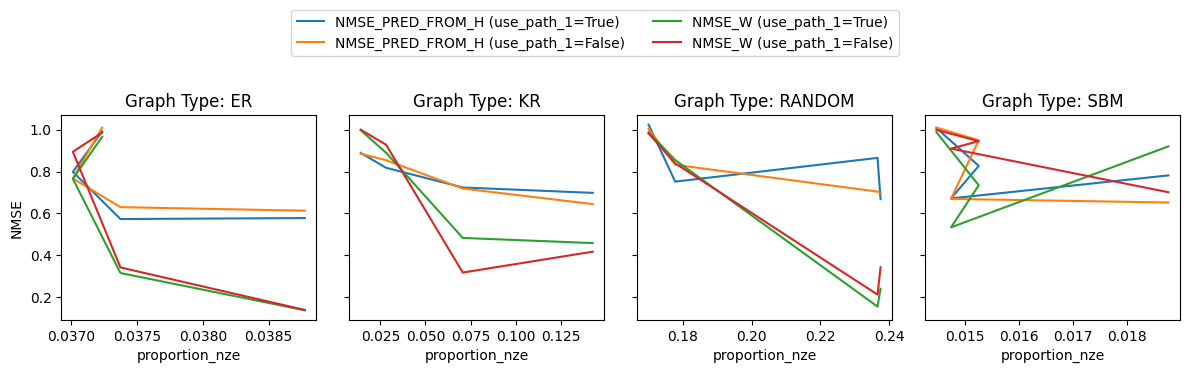

In [10]:

data = df_long[df_long['algorithm'] == 'alg2']

# Unique graph types
graph_types = data['graph_type'].unique()

# Set up the plot
fig, axes = plt.subplots(1, len(graph_types), figsize=(3*len(graph_types), 3), sharey=True)

for i, graph_type in enumerate(graph_types):
    ax = axes[i] if len(graph_types) > 1 else axes
    
    # Filter data for current graph type
    graph_data = data[data['graph_type'] == graph_type]
    
    # Plot NMSE_PRED_FROM_H
    for use_path_1 in ['True', 'False']:
        subset = graph_data[graph_data['use_path_1'] == use_path_1]
        ax.plot(subset['proportion_nze'], subset['nmse_pred_from_h'], 
                label=f'NMSE_PRED_FROM_H (use_path_1={use_path_1})',
                linestyle='-' if use_path_1 else '--')
    
    # Plot NMSE_W
    for use_path_1 in ['True', 'False']:
        subset = graph_data[graph_data['use_path_1'] == use_path_1]
        ax.plot(subset['proportion_nze'], subset['nmse_w'], 
                label=f'NMSE_W (use_path_1={use_path_1})',
                linestyle='-' if use_path_1 else '--')
    
    ax.set_xlabel('proportion_nze')
    ax.set_title(f'Graph Type: {graph_type}')
    # ax.set_yscale('log')  # Set y-axis to log scale
    
    if i == 0:
        ax.set_ylabel('NMSE')

# Add a single legend for all subplots
handles, labels = axes[-1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=2)

plt.tight_layout()
plt.show()

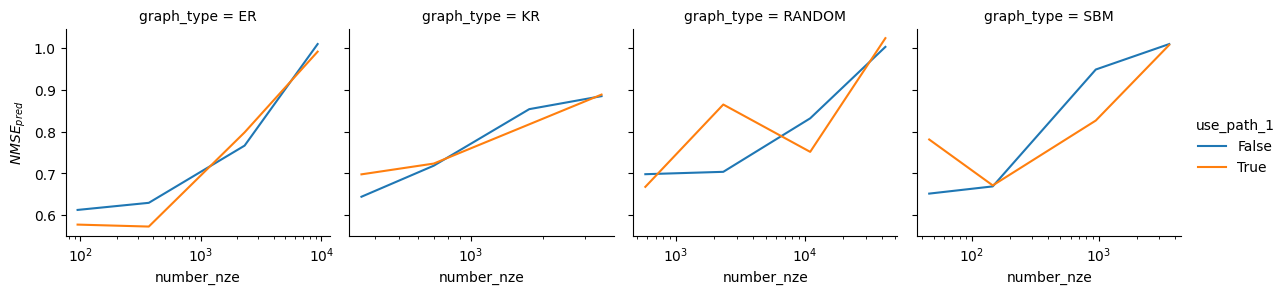

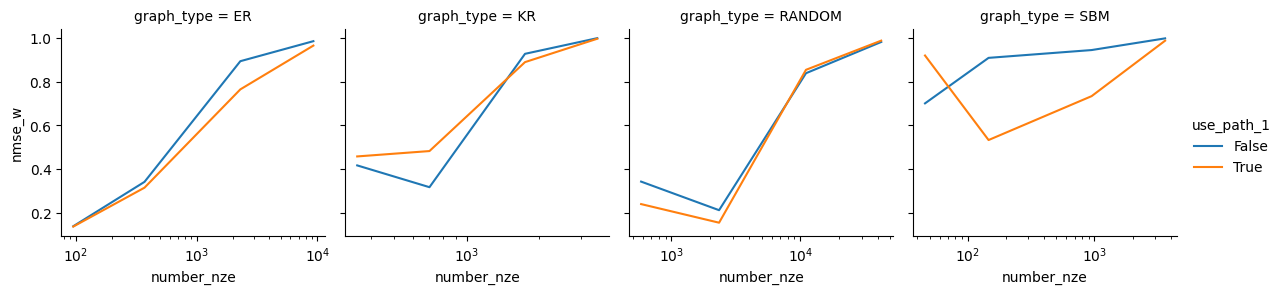

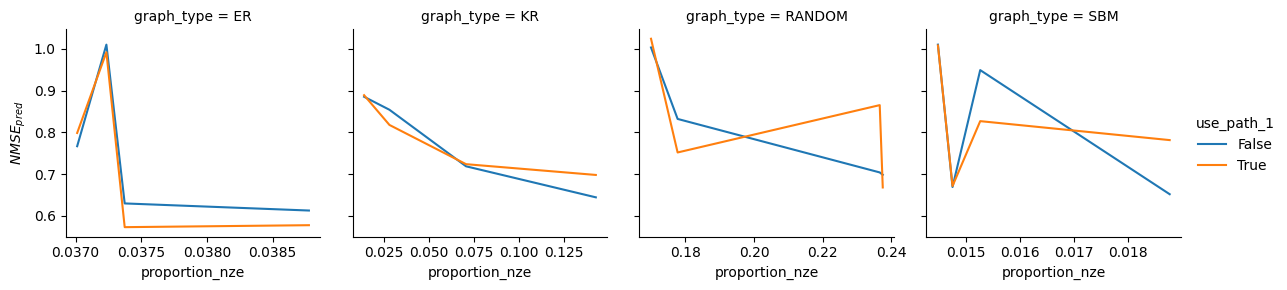

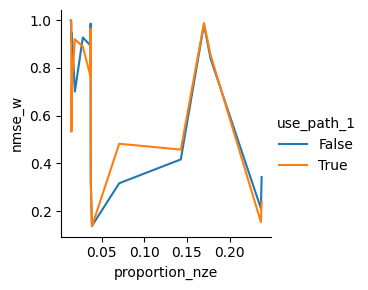

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# hue graph_type, x = N, y = nmse_pred_from_h
g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col='graph_type', hue="use_path_1", sharey=True, sharex=False)
g.map(sns.lineplot, "number_nze", "nmse_pred_from_h")
g.add_legend()
g.set(ylabel='$NMSE_{pred}$')
g.set(xscale="log")
plt.show()

g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col='graph_type', hue="use_path_1", sharey=True, sharex=False)
g.map(sns.lineplot, "number_nze", "nmse_w")
g.add_legend()
g.set(xscale="log")
plt.show()

g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col='graph_type', hue="use_path_1", sharey=True, sharex=False)
g.map(sns.lineplot, "proportion_nze", "nmse_pred_from_h")
g.add_legend()
g.set(ylabel='$NMSE_{pred}$')
# g.set(xscale="log")
plt.show()

g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], hue="use_path_1", sharey=True, sharex=False)
g.map(sns.lineplot, "proportion_nze", "nmse_w")
g.add_legend()
# g.set(xscale="log")
plt.show()


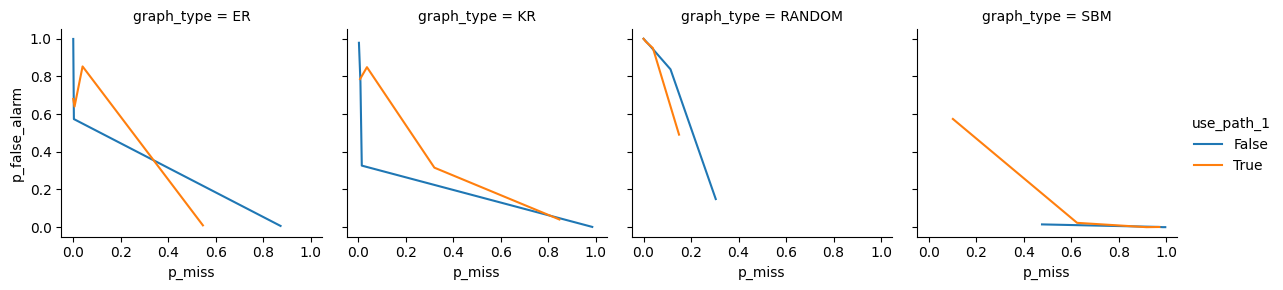

In [12]:
# plot prob missing against prob false alarm
g = sns.FacetGrid(df_long[df_long['algorithm'] == 'alg2'], col='graph_type', hue="use_path_1", sharey=True)
g.map(sns.lineplot, "p_miss", "p_false_alarm")
g.add_legend()
plt.show()

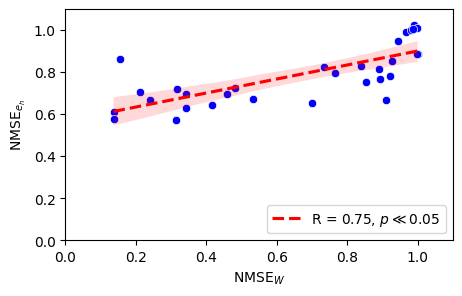

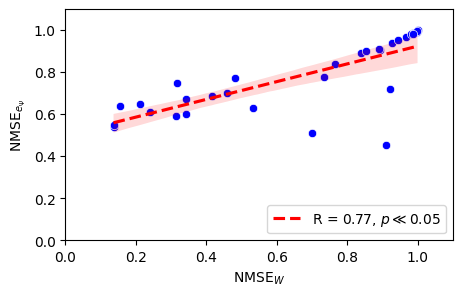

In [13]:
from scipy.stats import pearsonr

# plot prob missing against prob false alarm
# figure size
y = 'nmse_pred_from_h'
x = 'nmse_w'
data = df_long[df_long['algorithm'] == 'alg2']
plt.figure(figsize=(5, 3))
sns.scatterplot(x=x, y=y, data=data, color='b')
r, p = pearsonr(data[x], data[y])
p_label = f'p = {p:.2e}' if p > 0.01 else '$p \ll 0.05$'
sns.regplot(x=x, y=y, data=df_long[df_long['algorithm'] == 'alg2'], color='r', scatter=False, label=f'R = {r:.2f}, {p_label}', line_kws={'linestyle': '--'})
plt.legend(loc='lower right')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xlabel("NMSE$_{W}$")
plt.ylabel("NMSE$_{e_h}$")
plt.savefig('figures/nmse_pred_from_h_vs_nmse_w.svg')
plt.show()

# plot prob missing against prob false alarm
# figure size
y = 'nmse_pred'
x = 'nmse_w'
data = df_long[df_long['algorithm'] == 'alg2']
plt.figure(figsize=(5, 3))
sns.scatterplot(x=x, y=y, data=data, color='b')
r, p = pearsonr(data[x], data[y])
p_label = f'p = {p:.2e}' if p > 0.01 else '$p \ll 0.05$'
sns.regplot(x=x, y=y, data=data, color='r', scatter=False, label=f'R = {r:.2f}, {p_label}', line_kws={'linestyle': '--'})
plt.legend(loc='lower right')
plt.xlim(0, 1.1)
plt.ylim(0, 1.1)
plt.xlabel("NMSE$_{W}$")
plt.ylabel("NMSE$_{e_\Psi}$")

# save as .svg in \figures
plt.savefig('figures/nmse_pred_vs_nmse_w.svg')
plt.show()

In [14]:
# make into a latex table with columns graph_type with N=50, N=100, N=250, N=500 underneath is as sub columns
# and use_path_1 and algorithm as rows
# elements will be nmse_pred_from_h for first block of rows, nmse_w for second block of rows, pce for third block of rows, p_miss for fourth block of rows and p_false_alarm for fifth block of rows
# use_path_1 = True, False
# algorithm = alg1, alg2
# graph_type = RANDOM, KR, SBM, ER

# get the columns
cols = ['graph_type', 'N', 'use_path_1', 'algorithm', 'nmse_pred_from_h', 'nmse_w', 'pce', 'p_miss', 'p_false_alarm']
df_latex = df_long[cols]

# pivot the table
df_latex = df_latex.pivot(index=['graph_type', 'use_path_1', 'algorithm'], columns='N')
df_latex.columns = df_latex.columns.droplevel(0)

df_latex

,,N,50.0,100.0,250.0,500.0,50.0,100.0,250.0,500.0,50.0,100.0,250.0,500.0,50.0,100.0,250.0,500.0,50.0,100.0,250.0,500.0
graph_type,use_path_1,algorithm,,,,,,,,,,,,,,,,,,,,
ER,True,alg2,0.577589,0.572882,0.798520,0.991935,0.136709,0.314879,0.765122,0.965759,1.000000,0.994595,0.453993,0.960710,0.000000,0.005405,0.546007,0.039290,0.680665,0.639772,0.009635,0.853105
KR,True,alg2,0.697968,0.723780,0.817796,0.889029,0.457980,0.482577,0.890023,0.997143,0.680000,0.992857,0.964000,0.153429,0.320000,0.007143,0.036000,0.846571,0.315814,0.786237,0.849070,0.040730
RANDOM,True,alg2,0.667980,0.865229,0.751811,1.024219,0.239651,0.154398,0.854783,0.988399,0.850515,1.000000,0.990329,0.960551,0.149485,0.000000,0.009671,0.039449,0.491137,1.000000,0.984388,0.950504
SBM,True,alg2,0.781440,0.671469,0.826859,1.008143,0.920260,0.533091,0.734184,0.988208,0.083333,0.375000,0.898126,0.028427,0.916667,0.625000,0.101874,0.971573,0.000000,0.022949,0.574376,0.000898


In [23]:
df_long[df_long['algorithm'] == 'alg2'].groupby(by=['N', 'graph_type', 'use_path_1'])['nmse_pred_from_h', 'nmse_w', 'pce', 'p_miss', 'p_false_alarm'].mean()

/tmp/ipykernel_2914688/445656543.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df_long[df_long['algorithm'] == 'alg2'].groupby(by=['N', 'graph_type', 'use_path_1'])['nmse_pred_from_h', 'nmse_w', 'pce', 'p_miss', 'p_false_alarm'].mean()


nmse_pred_from_h    nmse_w       pce    p_miss  \
N     graph_type use_path_1                                                   
50.0  ER         False               0.612725  0.138221  1.000000  0.000000   
                 True                0.577589  0.136709  1.000000  0.000000   
      KR         False               0.644325  0.416887  0.991429  0.008571   
                 True                0.697968  0.457980  0.680000  0.320000   
      RANDOM     False               0.698325  0.342656  0.695876  0.304124   
                 True                0.667980  0.239651  0.850515  0.149485   
      SBM        False               0.651823  0.701047  0.522727  0.477273   
                 True                0.781440  0.920260  0.083333  0.916667   
100.0 ER         False               0.629732  0.341527  0.997297  0.002703   
                 True                0.572882  0.314879  0.994595  0.005405   
      KR         False               0.718677  0.317077  0.985714  0.014286   
                 True                0.723780  0.482577  0.992857  0.007143   
      RANDOM     False               0.704000  0.211727  1.000000  0.000000   
                 True                0.865229  0.154398  1.000000  0.000000   
      SBM        False               0.669107  0.909521  0.014493  0.985507   
                 True                0.671469  0.533091  0.375000  0.625000   
250.0 ER         False               0.766787  0.894263  1.000000  0.000000   
                 True                0.798520  0.765122  0.453993  0.546007   
      KR         False               0.854143  0.928028  0.997714  0.002286   
                 True                0.817796  0.890023  0.964000  0.036000   
      RANDOM     False               0.832149  0.839186  0.886479  0.113521   
                 True                0.751811  0.854783  0.990329  0.009671   
      SBM        False               0.949102  0.945299  0.033991  0.966009   
                 True                0.826859  0.734184  0.898126  0.101874   
500.0 ER         False               1.010133  0.985981  0.127018  0.872982   
                 True                0.991935  0.965759  0.960710  0.039290   
      KR         False               0.885263  0.999808  0.015143  0.984857   
                 True                0.889029  0.997143  0.153429  0.846571   
      RANDOM     False               1.003311  0.982301  0.973402  0.026598   
                 True                1.024219  0.988399  0.960551  0.039449   
      SBM        False               1.010118  0.998821  0.003609  0.996391   
                 True                1.008143  0.988208  0.028427  0.971573   

                             p_false_alarm  
N     graph_type use_path_1                 
50.0  ER         False            0.997921  
                 True             0.680665  
      KR         False            0.770698  
                 True             0.315814  
      RANDOM     False            0.149114  
                 True             0.491137  
      SBM        False            0.014658  
                 True             0.000000  
100.0 ER         False            0.573624  
                 True             0.639772  
      KR         False            0.326667  
                 True             0.786237  
      RANDOM     False            1.000000  
                 True             1.000000  
      SBM        False            0.000000  
                 True             0.022949  
250.0 ER         False            0.999983  
                 True             0.009635  
      KR         False            0.978584  
                 True             0.849070  
      RANDOM     False            0.837857  
                 True             0.984388  
      SBM        False            0.001380  
                 True             0.574376  
500.0 ER         False            0.006535  
                 True             0.853105  
      KR         False            0.001355  
                 True             0.0